In [1]:
import cv2
import numpy as np
from pathlib import Path
from boxmot import DeepOCSORT, StrongSORT, BoTSORT
from ultralytics import YOLO
from pathlib import Path

In [2]:
def initialize_tracker(model_weights, device='cuda:0', fp16=True):
    """
    Initialize the DeepOCSORT tracker with the given model weights and device.
    """
    tracker = BoTSORT(
        model_weights=model_weights,
        device=device,
        fp16=fp16
    )
    return tracker

def initialize_yolo(model_path):
    """
    Initialize the YOLO object detector with the given model path.
    """
    yolov8 = YOLO(model_path)
    return yolov8

In [3]:
class Rect:
    def __init__(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
    
    @property
    def bottom_center(self):
        return ((self.x1 + self.x2) // 2, self.y2)
    
    @property
    def width(self):
        return self.x2 - self.x1

class Color:
    def __init__(self, b, g, r):
        self.b = b
        self.g = g
        self.r = r

    @property
    def bgr_tuple(self):
        return (self.b, self.g, self.r)

def draw_ellipse(image, rect, color, thickness=2):
    center = rect.bottom_center
    axes = (int(rect.width), int(0.35 * rect.width))
    cv2.ellipse(
        image,
        center,
        axes,
        angle=0.0,
        startAngle=-45,
        endAngle=235,
        color=color.bgr_tuple,
        thickness=thickness,
        lineType=cv2.LINE_4
    )
    return image

def lab_to_rgb(lab_color):
    """
    Converts a single LAB color to RGB.
    """
    lab_image = np.array([[lab_color]], dtype=np.uint8)
    rgb_image = cv2.cvtColor(lab_image, cv2.COLOR_Lab2RGB)
    return rgb_image[0][0]

def create_new_file(file_name):
    """
    Check if a file already exists, if it does append a number to the file
    The number increases if a file_"number" exists
    """
    if Path(file_name).is_file():
        file = file_name.split(".")[0]
        extension = file_name.split(".")[1]
        last_char = file[len(file) - 1]
        if last_char.isnumeric():
            last_char = str(int(last_char) + 1)
            new_file =  file[:-1] + last_char + "." + extension
        else:
            last_char = "_1"
            new_file =  file + last_char + "." + extension
        
        return create_new_file(new_file)
    else:
        return file_name

In [4]:
def plot_kmeans_clusters(player_mean_colors, labels):
    player_mean_colors = np.array([lab_to_rgb(color) for color in player_mean_colors])

    # Plotting the results (optional)
    plt.subplot(1, 2, 1)
    plt.scatter(player_mean_colors[:, 1], player_mean_colors[:, 2], c=player_mean_colors / 255.0)
    plt.title('Original Colors')

    plt.subplot(1, 2, 2)
    plt.scatter(player_mean_colors[labels == 0][:, 1], player_mean_colors[labels == 0][:, 2], c='blue', marker='o')
    plt.scatter(player_mean_colors[labels == 1][:, 1], player_mean_colors[labels == 1][:, 2], c='red', marker='x')
    plt.title('Clustered Colors')

    plt.show()
    
def home_away_color_ranges(home, away):
    # plot_lab_region(home[0], home[1])
    plot_lab_region(away[0], away[1])

    plt.figure(figsize=(10, 5))

    # Displaying the mask
    plt.subplot(1, 4, 1)
     # Plotting the most common color
    plt.imshow(cv2.cvtColor(home[0][np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Home Lower")

    plt.subplot(1, 4, 2)
    plt.imshow(cv2.cvtColor(home[1][np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Home Upper")

    plt.subplot(1, 4, 3)
    plt.imshow(cv2.cvtColor(away[0][np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Away Lower")

    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(away[1][np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Away Upper")

    plt.show()

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import sys
import sklearn
from collections import Counter


def adjust_bbox(image, bbox, height_fraction=(0.17, 0.5), width_fraction=(0.2, 0.2)):
    x1, y1, x2, y2 = bbox
    
    # Adjusting the bounding box to focus on the upper part
    height = y2 - y1
    width = x2 - x1
    
    new_y1 = y1 + int(height_fraction[0] * height)
    new_y2 = y1 + int(height_fraction[1] * height)
    new_x1 = x1 + int(width_fraction[0] * width)
    new_x2 = x2 - int(width_fraction[1] * width)

    adjusted_bbox = (new_x1, new_y1, new_x2, new_y2)
    roi = image[adjusted_bbox[1]:adjusted_bbox[3], adjusted_bbox[0]:adjusted_bbox[2]]

    return roi

def filter_out_color_LAB(roi_lab, lower_treshold, upper_treshold):
    # Getting the A channel and applying threshold
    a_channel = roi_lab[:,:,1]
    #127, 255
    _, mask = cv2.threshold(a_channel, lower_treshold, upper_treshold, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Using the mask to exclude green pixels in LAB
    roi_lab_filtered = roi_lab.copy()
    roi_lab_filtered[mask != 255] = 0
    return roi_lab_filtered

def get_color_histogram(image, bbox):
    """
    Get the color histogram within a specific portion of the bounding box in the HSV color space.
    """
    roi = adjust_bbox(image, bbox)
    # Converting to LAB color space
    roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2Lab)
    roi_lab_filtered = filter_out_color_LAB(roi_lab, 127, 255)
    
    non_black_pixels = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]
    color_counter = Counter(map(tuple, non_black_pixels))
    most_common_color = color_counter.most_common(1)[0][0]
        
    non_zero_subarrays = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]
    
    hist = cv2.calcHist([roi_lab], [0, 1], None, [8, 8], [0, 180, 0, 256])
    
    cv2.normalize(hist, hist)
    
    return hist.flatten()

def get_mean_color(image, bbox):
    """
    Get the mean color within a specific portion of the bounding box in both RGB and LAB color spaces,
    excluding green pixels.
    """
    roi = adjust_bbox(image, bbox)

    # Converting to LAB color space
    roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2Lab)
    roi_lab_filtered = filter_out_color_LAB(roi_lab, 127, 255)
        
    non_zero_subarrays = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]

    # Calculate the mean of each channel
    if non_zero_subarrays.size > 0:
        mean_color_lab = non_zero_subarrays.mean(axis=0)
        
        
    color_counter = Counter(map(tuple, non_zero_subarrays))
    most_common_color_lab = np.array(color_counter.most_common(1)[0][0], dtype=np.uint8)

    most_common_color_bgr = cv2.cvtColor(np.array([[most_common_color_lab]], dtype=np.uint8), cv2.COLOR_Lab2BGR)[0][0]
    mean_color_bgr = cv2.cvtColor(np.array([[mean_color_lab]], dtype=np.uint8), cv2.COLOR_Lab2BGR)[0][0]
    return most_common_color_lab, mean_color_lab

def perform_kmeans_clustering(colors, initial_centroids, color_multiplier=4, max_iter=10, n_clusters=2):
    """
    Perform k-means clustering on the given color data.
    """
    colors = np.array(colors)
    
    colors[:,1:3] *= 4
    if len(initial_centroids) != 0:
        kmeans = KMeans(n_clusters=2, init=initial_centroids, random_state=0, n_init=1, max_iter=max_iter).fit(colors)
    else:
        kmeans = KMeans(n_clusters=2, random_state=0).fit(colors)
        initial_centroids = kmeans.cluster_centers_
        
    # Reassign labels based on the order of centroids
    sorted_idx = np.argsort(initial_centroids[:, 0])  # Assuming the 0th feature is a color channel like Red
    mapping = np.zeros(n_clusters, dtype=int)
    for i, idx in enumerate(sorted_idx):
        mapping[idx] = i

    consistent_labels = mapping[kmeans.labels_]
    
    return consistent_labels, initial_centroids

In [10]:
from scipy.spatial import distance
from scipy import stats
    
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection



def plot_filtered_boxes(frame, boxes):
    plt.figure(figsize=(12, len(boxes) * 4))
    
    for i, box in enumerate(boxes):
        # Apply the ROI adjustment and color filtering
        roi = adjust_bbox(frame, box)
        roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2Lab)
        roi_lab_filtered = filter_out_color_LAB(roi_lab, 127, 255)
        non_zero_colors = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]

        plt.subplot(len(boxes), 2, i * 2 + 1)
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.title(f"Original Box {i+1}")

        plt.subplot(len(boxes), 2, i * 2 + 2)
        plt.imshow(cv2.cvtColor(roi_lab_filtered, cv2.COLOR_Lab2RGB))
        plt.title(f"Filtered Box {i+1}")
        
    plt.show()

def compute_common_color_cluster_and_range(frame, boxes, num_clusters=2, delta=10):
    colors = []
    for box in boxes:
        roi = adjust_bbox(frame, box)
        roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2Lab)
        roi_lab_filtered = filter_out_color_LAB(roi_lab, 127, 255)
        non_zero_colors = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]
        colors.extend(non_zero_colors)

    if len(colors) == 0:
        print("All colors are filtered out.")
        return None, None

    # Applying K-means clustering to group colors
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(colors)
    cluster_centers = kmeans.cluster_centers_.astype(int)

    # Getting the most common cluster center (centroid)
    labels, counts = np.unique(kmeans.labels_, return_counts=True)
    most_common_cluster = cluster_centers[labels[np.argmax(counts)]]

    # Compute the color range
    lower_bound = np.clip(most_common_cluster - delta, 0, 255)
    upper_bound = np.clip(most_common_cluster + delta, 0, 255)

    # Plotting the most common color cluster center
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(most_common_cluster[np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Most Common Cluster Center")
    plt.axis('off')

    # Plotting colors within the range
    plt.subplot(1, 2, 2)
    for i in range(5):
        sample_color = np.random.randint(lower_bound, upper_bound+1)
        plt.imshow(cv2.cvtColor(sample_color[np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
        plt.title("Colors Within Range")
        plt.axis('off')

    plt.show()

    return lower_bound, upper_bound    
    
def compute_common_color_and_range(frame, boxes, delta=10):
    colors = []
    for box in boxes:
        roi = adjust_bbox(frame, box)
        roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2Lab)
        roi_lab_filtered = filter_out_color_LAB(roi_lab, 127, 255)
        non_zero_colors = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]
        colors.extend(non_zero_colors)

    if len(colors) == 0:
        print("All colors are filtered out.")
        return None, None

    color_counter = Counter(map(tuple, colors))
    most_common_color = np.array(color_counter.most_common(1)[0][0], dtype=np.uint8)

    # Compute the color range
    lower_bound = most_common_color - delta
    upper_bound = most_common_color + delta
    
    # Ensure the bounds are valid
    if np.any(upper_bound < lower_bound):
        print("Invalid color range corrected.")
        lower_bound = most_common_color
        upper_bound = most_common_color
    
    lower_bound = np.clip(lower_bound, 0, 255)
    upper_bound = np.clip(upper_bound, 0, 255)

    # Plotting the most common color
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(most_common_color[np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Most Common Color")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    for i in range(5):
        sample_color = np.random.randint(lower_bound, upper_bound + 1, size=(1,1,3))
        plt.imshow(cv2.cvtColor(sample_color.astype(np.uint8), cv2.COLOR_Lab2RGB))
        plt.axis('off')

    return lower_bound, upper_bound


def nearest_points(centroids, data_points, n):
    # Calculate the distances between each data point and each centroid
    distances = distance.cdist(data_points, centroids, 'euclidean')
    
    # Get the n smallest distances' indices for each centroid
    nearest_indices = np.argsort(distances, axis=0)[:n]
    
    # Creating a dictionary to hold the indices of the nearest points for each centroid
    nearest_per_centroid = {i: nearest_indices[:, i].tolist() for i in range(centroids.shape[0])}

    return nearest_per_centroid


def compute_jersey_colors(first_frame, dets, bounding_boxes, classes, color_multiplier=4):
    # get_mean_color returns a tuple, 0 is most common color, 1 is mean color
    class_1_boxes = [bounding_box for bounding_box, cls in zip(bounding_boxes, classes) if cls == 1]
    colors_bounding_boxes = [(get_mean_color(first_frame, bounding_box)[1], bounding_box) for bounding_box in class_1_boxes]
    
    mean_colors = []
    for color_bbox in colors_bounding_boxes:
        mean_colors.append(color_bbox[0])
    
    initial_centroids = []
    mean_colors = np.array(mean_colors)
    label_clusters, centroids = perform_kmeans_clustering(mean_colors, initial_centroids, color_multiplier=color_multiplier)
    clustered_points = mean_colors.copy()
    clustered_points[:,1:3] *= color_multiplier
    
    close_points = nearest_points(centroids, clustered_points, 4)
    
    centroid_1_boxes = [class_1_boxes[i] for i in close_points[0]]
    centroid_2_boxes = [class_1_boxes[i] for i in close_points[1]]
    
    
    #plot_filtered_boxes(first_frame, centroid_1_boxes)
    #plot_filtered_boxes(first_frame, centroid_2_boxes)
    print("first")
    home1 = compute_common_color_cluster_and_range(first_frame, centroid_1_boxes)
    home = compute_common_color_and_range(first_frame, centroid_1_boxes)

    print("second")
    away1 = compute_common_color_cluster_and_range(first_frame, centroid_2_boxes)
    away = compute_common_color_and_range(first_frame, centroid_2_boxes)


    print("Most Dominant Color (in LAB):", away1)
    return (home, away)
    

def plot_lab_region(lower_bound, upper_bound):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Define the vertices of the region
    # Each vertex is a combination of the lower and upper values for L, a, and b
    vertices = [
        [lower_bound[0], lower_bound[1], lower_bound[2]],
        [upper_bound[0], lower_bound[1], lower_bound[2]],
        [upper_bound[0], upper_bound[1], lower_bound[2]],
        [lower_bound[0], upper_bound[1], lower_bound[2]],
        [lower_bound[0], lower_bound[1], upper_bound[2]],
        [upper_bound[0], lower_bound[1], upper_bound[2]],
        [upper_bound[0], upper_bound[1], upper_bound[2]],
        [lower_bound[0], upper_bound[1], upper_bound[2]]
    ]
    
    vertices = np.array(vertices)
    
    # Define the vertices that compose each of the 6 faces of the region
    faces = [
        [vertices[0], vertices[1], vertices[2], vertices[3]],
        [vertices[4], vertices[5], vertices[6], vertices[7]], 
        [vertices[0], vertices[1], vertices[5], vertices[4]], 
        [vertices[1], vertices[2], vertices[6], vertices[5]],
        [vertices[2], vertices[3], vertices[7], vertices[6]],
        [vertices[3], vertices[0], vertices[4], vertices[7]]
    ]
    
    # Draw the faces
    ax.add_collection3d(Poly3DCollection(faces, facecolors='cyan', linewidths=1, edgecolors='black', alpha=.25))
    
    ax.set_xlabel('L*')
    ax.set_ylabel('a*')
    ax.set_zlabel('b*')
    ax.set_xlim([0, 255])
    ax.set_ylim([-255, 255])
    ax.set_zlim([-255, 255])
    plt.show()

        
def get_team_belonging(image, bounding_box, home_color, away_color, should_plot=False):
    #blur_kernel_size = (2,2)
    #image = cv2.blur(image, blur_kernel_size)
    roi = adjust_bbox(image, bounding_box)
    
    # Converting to LAB color space
    roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2LAB)
    
    roi_lab_away = roi_lab.copy()
    roi_lab_referee = roi_lab.copy()
    
    lower_blue = np.array([100, 50, 50])
    upper_blue = np.array([140, 255, 255])
    
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 50, 255])
    
    
    mask_home = cv2.inRange(roi_lab, home_color[0], home_color[1])
    #mask_home = cv2.inRange(roi_lab, lower_blue, upper_blue)
    result_home = cv2.bitwise_and(roi_lab, roi_lab, mask=mask_home)
    count_home = cv2.countNonZero(mask_home)
    
    mask_away = cv2.inRange(roi_lab_away, away_color[0], away_color[1])
    #mask_away = cv2.inRange(roi_lab_away, lower_white, upper_white)
    result_away = cv2.bitwise_and(roi_lab_away, roi_lab_away, mask=mask_away)
    count_away = cv2.countNonZero(mask_away)
    
    if should_plot:
        plt.figure(figsize=(10, 5))
        # Displaying the mask
        plt.subplot(1, 5, 1)
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.title("Result")

        plt.subplot(1, 5, 2)
        plt.imshow(mask_home, cmap='gray')
        plt.title("Mask Home")

        # Displaying the result
        plt.subplot(1, 5, 3)
        plt.imshow(cv2.cvtColor(result_home, cv2.COLOR_HSV2RGB))
        plt.title("Result Home")

        plt.subplot(1, 5, 4)
        plt.imshow(mask_away, cmap='gray')
        plt.title("Mask Away")

        # Displaying the result
        plt.subplot(1, 5, 5)
        plt.imshow(cv2.cvtColor(result_away, cv2.COLOR_HSV2RGB))
        plt.title("Result Away")

        plt.show()
        
        
    team = -1
    
    if count_away > count_home:
        team = 1
        print("Away team")
    else:
        print("Home team")
        team = 0
        
    return team

In [11]:
import os
import cv2
import zipfile

# Function to get unique colors for each class id
def get_color(cls_id):
    np.random.seed(cls_id)
    return tuple(np.random.randint(0, 255, 3).tolist())

def split_ball_players(detections):
    dets = []
    ball = np.array([])
    highest_conf = 0

    for bounding_boxes in detections:
        if bounding_boxes[-1:] != 0:
            dets.append(bounding_boxes)
        if bounding_boxes[5] == 0:
            if bounding_boxes[4] > highest_conf:
                highest_conf = bounding_boxes[4]
                ball = bounding_boxes


    dets = np.array(dets)
    
    return dets, ball

def draw_on_frame(image, xyxys, ids, clss, labels, ball):
    thickness = 2
    fontscale = 0.5

    
    for xyxy, id, cls, label in zip(xyxys, ids, clss, labels):


        # Convert bounding box coordinates to Rect object
        rect = Rect(xyxy[0], xyxy[1], xyxy[2], xyxy[3])
        if cls == 1:
            cls = cls + label

        # Get a unique color for each class
        color = Color(*get_color(cls))

        # Draw an ellipse at the bottom of the bounding box
        draw_ellipse(image, rect, color, thickness)

        # Place ID text just above the ellipse
        cv2.putText(
            image,
            f'{id}',
            (rect.bottom_center[0] - 10, rect.bottom_center[1] - int(0.35 * rect.width) - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontscale,
            color.bgr_tuple,
            thickness
        )
    if len(ball) != 0:
        rect = Rect(int(ball[0]), int(ball[1]), int(ball[2]), int(ball[3]))
        # Get a unique color for each class
        color = Color(*get_color(0))

        # Draw an ellipse at the bottom of the bounding box
        draw_ellipse(image, rect, color, thickness)
        id = -1
        # Place ID text just above the ellipse
        cv2.putText(
            image,
            "-1",
            (rect.bottom_center[0] - 10, rect.bottom_center[1] - int(0.35 * rect.width) - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontscale,
            color.bgr_tuple,
            thickness
        )
        
        
def save_frame_as_image(frame, output_folder, frame_id):
    """Save the current frame as an image."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    filename = os.path.join(output_folder, f"{frame_id:06}.jpg")
    print("Saved: " + filename)
    cv2.imwrite(filename, frame)

def write_labels_txt(class_names, filepath):
    """Write class names to labels.txt."""
    with open(filepath, "w") as f:
        for name in class_names:
            f.write(name + "\n")

def export_to_mot_format(frames, track_ids, bboxes, class_ids, filepath):
    """Write the tracking results into gt.txt in the MOT format."""
    with open(filepath, 'w') as f:
        for frame_num, track_id, bbox, class_id in zip(frames, track_ids, bboxes, class_ids):
            x1, y1, x2, y2 = bbox
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            w = x2 - x1
            h = y2 - y1
            f.write(f"{frame_num},{track_id},{x1},{y1},{w},{h},1,{class_id},0.86014\n")


In [12]:
def process_video(input_file, output_file, tracker, yolov8, do_kmeans, conf=0.3, should_plot=False, class_names=None):
    """
    Process the input video, perform object detection and tracking, and save the results to the output video.
    """
    input_video = cv2.VideoCapture(input_file)
    width = int(input_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(input_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = input_video.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, fps, (width, height))
  
    initial_centroids = []
    counter = 1
    while True:
        print(counter)
        ret, image = input_video.read()
        if not ret:
            break
        
       
        predicted = yolov8.predict(image, conf=conf)
        detections = predicted[0].boxes.data.cpu().numpy()
        
        # Split the ball detections and player detections into two arrays
        # This ensures the labels are correct when doing team assignment
        # and that we only get 1 ball in each frame
        dets, ball = split_ball_players(detections)
        
        tracks = tracker.update(dets, image)
        
        # Set im = image so we can do transforms on the image for better color identification
        # Without altering the original image so when writing the video it looks the same
        #im = cv2.addWeighted(image, 0.75, image, 0.5, 0)
        im = image
        
        if tracks.size > 0:  # Check if tracks is not empty
            xyxys = tracks[:, 0:4].astype('int')
            ids = tracks[:, 4].astype('int')
            clss = tracks[:, 6].astype('int')
        else:
            print("Tracks is empty or not in expected format.")

        if(counter == 1):
            home, away = compute_jersey_colors(im, dets, xyxys, clss)
            
            if should_plot:
                home_away_color_ranges(home, away)
            
            
        if tracks.shape[0] != 0:
            player_mean_colors = [get_mean_color(im, xyxy)[1] for xyxy, cls in zip(xyxys, clss) if cls == 1]
            #player_mean_colors = [get_color_histogram(im, xyxy) for xyxy, cls in zip(xyxys, clss) if cls == 1]
            
            if(len(initial_centroids) == 0):
                labels, initial_centroids = perform_kmeans_clustering(player_mean_colors, initial_centroids)

            else:
                if do_kmeans:
                    labels = perform_kmeans_clustering(player_mean_colors, initial_centroids)[0]
                else:
                    labels = [get_team_belonging(im, xyxy, home, away) for xyxy, cls in zip(xyxys, clss) if cls == 1]
            
            if should_plot:
                plot_kmeans_clusters(player_mean_colors, labels)   
    
            draw_on_frame(image, xyxys, ids, clss, labels, ball)

        out.write(image)
        counter += 1
        
    input_video.release()
    out.release()
    cv2.destroyAllWindows()


2023-11-01 10:05:38.527 | SUCCESS  | boxmot.appearance.reid_model_factory:load_pretrained_weights:207 - Successfully loaded pretrained weights from "osnet_x1_0_market1501.pt"


Tracking output: videos/30sec_BODO_tracking_output_test_1.mp4
1



0: 1088x1920 1 ball, 22 players, 18.6ms
Speed: 9.9ms preprocess, 18.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


first


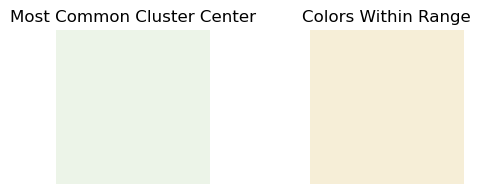

Invalid color range corrected.
second


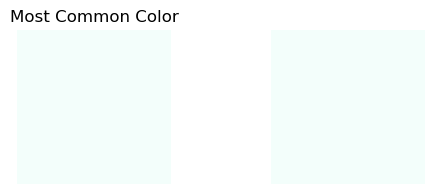

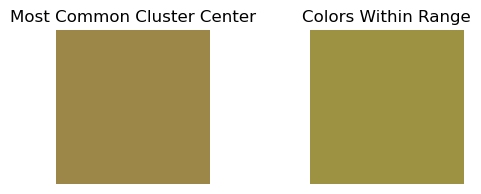


0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


Most Dominant Color (in LAB): (array([135, 118, 154]), array([155, 138, 174]))
2
3



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


4



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


5



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


6



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


7



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


8



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


9



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


10



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


11



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


12



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


13



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


14



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


15



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


16



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


17



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


18



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


19



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


20



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


21



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


22



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


23



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


24



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


25



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 11.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


26



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


27



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


28



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


29



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


30



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


31



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


32



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


33



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


34



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


35



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


36



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


37



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


38



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


39



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


40



0: 1088x1920 1 ball, 22 players, 18.1ms
Speed: 7.5ms preprocess, 18.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


41



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


42



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


43



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


44



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


45



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


46



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


47



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


48



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


49



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


50



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


51



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 8.0ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


52



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


53



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


54



0: 1088x1920 1 ball, 22 players, 18.0ms
Speed: 7.6ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


55



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


56



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


57



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


58



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


59



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


60



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


61



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


62



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


63



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


64



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


65



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


66



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


67



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


68



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 8.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


69



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


70



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


71



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


72



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


73



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


74



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


75



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


76



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


77



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


78



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


79



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


80



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


81



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


82



0: 1088x1920 1 ball, 22 players, 18.6ms
Speed: 7.7ms preprocess, 18.6ms inference, 1.5ms postprocess per image at shape (1, 3, 1088, 1920)


83



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


84



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


85



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


86



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


87



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


88



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


89



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


90



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


91



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


92



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


93



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


94



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


95



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


96



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


97



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


98



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


99



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


100



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 8.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


101



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


102



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


103



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


104



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


105



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


106



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


107



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


108



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


109



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


110



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


111



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


112



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


113



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


114



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


115



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


116



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


117



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


118



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


119



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


120



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


121



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


122



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


123



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


124



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


125



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


126



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


127



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


128



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


129



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


130



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


131



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 6.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


132



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


133



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


134



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


135



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


136



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


137



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


138



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


139



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


140



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


141



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 8.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


142



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 8.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


143



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


144



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


145



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


146



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


147



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


148



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


149



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


150



0: 1088x1920 1 ball, 22 players, 35.0ms
Speed: 7.3ms preprocess, 35.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


151



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


152



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


153



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


154



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


155



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


156



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


157



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


158



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


159



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


160



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 8.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


161



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


162



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


163



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


164



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


165



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


166



0: 1088x1920 1 ball, 22 players, 42.1ms
Speed: 7.3ms preprocess, 42.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1088, 1920)


167



0: 1088x1920 1 ball, 22 players, 34.8ms
Speed: 7.3ms preprocess, 34.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


168
169



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


170
171



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


172
173



0: 1088x1920 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


174
175



0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 8.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


176
177



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


178
179



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


180
181



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


182
183



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


184
185



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


186
187



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


188
189



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


190
191



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


192
193



0: 1088x1920 1 ball, 22 players, 35.4ms
Speed: 7.2ms preprocess, 35.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


194
195



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


196
197



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


198
199



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


200
201



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


202
203



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


204
205



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


206
207



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


208
209



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


210
211



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


212
213



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


214
215



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


216
217



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


218
219



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


220
221



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


222
223



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


224
225



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


226
227



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


228
229



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


230
231



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


232
233



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


234
235



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


236
237



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


238
239



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


240
241



0: 1088x1920 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


242
243



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


244
245



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


246
247



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


248
249



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


250
251



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


252
253



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


254
255



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


256
257



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


258
259



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


260
261



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


262
263



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


264
265



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


266
267



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


268
269



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


270
271



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


272
273



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


274
275



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


276
277



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


278
279



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


280
281



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


282
283



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


284
285



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


286
287



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


288
289



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


290
291



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


292
293



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


294
295



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


296
297



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 32.4ms
Speed: 7.5ms preprocess, 32.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


298
299



0: 1088x1920 1 ball, 22 players, 28.2ms
Speed: 7.5ms preprocess, 28.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


300



0: 1088x1920 1 ball, 22 players, 24.0ms
Speed: 7.4ms preprocess, 24.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


301
302



0: 1088x1920 1 ball, 22 players, 36.7ms
Speed: 7.3ms preprocess, 36.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


303
304



0: 1088x1920 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


305
306



0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


307
308



0: 1088x1920 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


309
310



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


311
312



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


313
314



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


315
316



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


317
318



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


319
320



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


321
322



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


323
324



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 8.0ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


325
326



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


327
328



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


329
330



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


331
332



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


333
334



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


335
336



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


337
338



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


339
340



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


341
342



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


343
344



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


345
346



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 8.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


347
348



0: 1088x1920 22 players, 17.9ms
Speed: 8.0ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


349
350



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


351
352



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


353
354



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


355
356



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


357
358



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


359
360



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


361
362



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


363
364



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


365
366



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


367
368



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


369
370



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 8.0ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


371
372



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


373
374



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


375
376



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


377
378



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


379
380



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


381
382



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


383
384



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


385
386



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


387
388



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


389
390



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


391
392



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


393
394



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


395
396



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


397
398



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


399
400



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


401
402



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


403
404



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


405
406



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


407
408



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


409
410



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


411
412



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


413
414



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


415
416



0: 1088x1920 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


417
418



0: 1088x1920 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


419
420



0: 1088x1920 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


421
422



0: 1088x1920 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


423
424



0: 1088x1920 2 balls, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


425
426



0: 1088x1920 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


427
428



0: 1088x1920 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


429
430



0: 1088x1920 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 2 balls, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


431
432



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


433
434



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


435
436



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


437
438



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


439
440



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


441
442



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


443
444



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


445
446



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1088, 1920)


447
448



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


449
450



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


451
452



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


453
454



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


455
456



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


457
458



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


459
460



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


461
462



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


463
464



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


465
466



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


467
468



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


469
470



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


471
472



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


473
474



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


475
476



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 8.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


477
478



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


479
480



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


481
482



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


483
484



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


485
486



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 18.5ms
Speed: 7.2ms preprocess, 18.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


487
488



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 2 balls, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


489
490



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


491
492



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


493
494



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


495
496



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


497
498



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


499
500



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


501
502



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


503
504



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


505
506



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 10.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


507
508



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


509
510



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


511
512



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


513
514



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


515
516



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


517
518



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


519
520



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


521
522



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


523
524



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


525
526



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


527
528



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


529
530



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


531
532



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


533
534



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


535
536



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 18.0ms
Speed: 7.9ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 1088, 1920)


537
538



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


539
540



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


541
542



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


543
544



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


545
546



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


547
548



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


549
550



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


551
552



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


553
554



0: 1088x1920 1 ball, 23 players, 18.0ms
Speed: 7.7ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


555
556



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


557
558



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


559
560



0: 1088x1920 1 ball, 23 players, 24.6ms
Speed: 7.4ms preprocess, 24.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


561
562



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


563
564



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


565
566



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


567
568



0: 1088x1920 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


569
570



0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


571
572



0: 1088x1920 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


573
574



0: 1088x1920 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


575
576



0: 1088x1920 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


577
578



0: 1088x1920 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


579
580



0: 1088x1920 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


581
582



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


583
584



0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


585
586



0: 1088x1920 24 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


587
588



0: 1088x1920 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


589
590



0: 1088x1920 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


591
592



0: 1088x1920 3 balls, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


593
594



0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


595
596



0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


597
598



0: 1088x1920 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


599
600



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


601
602



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


603
604



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


605
606



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


607
608



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


609
610



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


611
612



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


613
614



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


615
616



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 3.0ms postprocess per image at shape (1, 3, 1088, 1920)


617
618



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


619
620



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 6.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


621
622



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


623
624



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 3.1ms postprocess per image at shape (1, 3, 1088, 1920)


625
626



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


627
628



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


629
630



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


631
632



0: 1088x1920 23 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


633
634



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


635
636



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


637
638



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


639
640



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


641
642



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


643
644



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


645
646



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


647
648



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


649
650



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


651
652



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


653
654



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


655
656



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


657
658



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


659
660



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


661
662



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


663
664



0: 1088x1920 1 ball, 23 players, 18.0ms
Speed: 8.0ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


665
666



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


667
668



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


669
670



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


671
672



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


673
674



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


675
676



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


677
678



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


679
680



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


681
682



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


683
684



0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


685
686



0: 1088x1920 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


687
688



0: 1088x1920 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


689
690



0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


691
692



0: 1088x1920 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


693
694



0: 1088x1920 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


695
696



0: 1088x1920 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


697
698



0: 1088x1920 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


699
700



0: 1088x1920 23 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


701
702



0: 1088x1920 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


703
704



0: 1088x1920 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


705
706



0: 1088x1920 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


707
708



0: 1088x1920 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


709
710



0: 1088x1920 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


711
712



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


713
714



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


715
716



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


717
718



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


719
720



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


721
722



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


723
724



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


725
726



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


727
728



0: 1088x1920 1 ball, 25 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


729
730



0: 1088x1920 1 ball, 25 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


731
732



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


733
734



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


735
736



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


737
738



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 2 balls, 24 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


739
740



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


741
742



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


743
744



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


745
746



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


747
748



0: 1088x1920 24 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 24 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


749
750



0: 1088x1920 24 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 24 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


751
752



0: 1088x1920 24 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 24 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


753
754



0: 1088x1920 24 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 24 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


755
756



0: 1088x1920 24 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 25 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


757
758



0: 1088x1920 1 ball, 25 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 25 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


759
760



0: 1088x1920 2 balls, 24 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


761
762



0: 1088x1920 24 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 2 balls, 24 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


763
764



0: 1088x1920 2 balls, 24 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 2 balls, 24 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


765
766



0: 1088x1920 2 balls, 24 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 3 balls, 24 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


767
768



0: 1088x1920 2 balls, 24 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 2 balls, 24 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


769
770



0: 1088x1920 3 balls, 25 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 2 balls, 25 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


771
772



0: 1088x1920 1 ball, 25 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 25 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


773
774



0: 1088x1920 1 ball, 26 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 27 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


775
776



0: 1088x1920 26 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 26 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


777
778



0: 1088x1920 25 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 26 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


779
780



0: 1088x1920 24 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 25 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


781
782



0: 1088x1920 25 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 18.0ms
Speed: 7.2ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


783
784



0: 1088x1920 24 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


785
786



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


787
788



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


789
790



0: 1088x1920 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


791
792



0: 1088x1920 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


793
794



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


795
796



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


797
798



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


799
800



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


801
802



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


803
804



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


805
806



0: 1088x1920 21 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


807
808



0: 1088x1920 21 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 8.3ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


809
810



0: 1088x1920 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


811
812



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


813
814



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 2 balls, 21 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


815
816



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


817
818



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


819
820



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


821
822



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


823
824



0: 1088x1920 21 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


825
826



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


827
828



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


829
830



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


831
832



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


833
834



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


835
836



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


837
838



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


839
840



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


841
842



0: 1088x1920 1 ball, 21 players, 31.9ms
Speed: 7.1ms preprocess, 31.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


843
844



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


845
846



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


847
848



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


849
850



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


851
852



0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 18.0ms
Speed: 7.2ms preprocess, 18.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


853
854



0: 1088x1920 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


855
856



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


857
858



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


859
860



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


861
862



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


863
864



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 18.0ms
Speed: 7.2ms preprocess, 18.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


865
866



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)



867
868


0: 1088x1920 1 ball, 23 players, 30.0ms
Speed: 7.4ms preprocess, 30.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 20.2ms
Speed: 7.1ms preprocess, 20.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


869
870



0: 1088x1920 1 ball, 22 players, 48.6ms
Speed: 7.1ms preprocess, 48.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 33.9ms
Speed: 7.4ms preprocess, 33.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


871



0: 1088x1920 1 ball, 22 players, 23.2ms
Speed: 7.1ms preprocess, 23.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


872



0: 1088x1920 1 ball, 22 players, 35.3ms
Speed: 7.6ms preprocess, 35.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


873
874



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


875
876



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


877
878



0: 1088x1920 2 balls, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


879
880



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


881
882



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


883
884



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


885
886



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 2 balls, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


887
888



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


889
890



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


891
892



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


893
894



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


895
896



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 8.1ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


897
898



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


899
900



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 8.1ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


901
902
Time taken to process video: 113.34490942955017 seconds


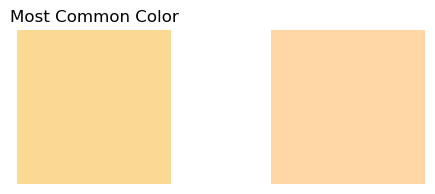

In [13]:
from pathlib import Path
import warnings
import time

warnings.filterwarnings("ignore")
model_weights = Path('osnet_x1_0_market1501.pt')
yolo_model_path = 'runs/detect/6600_Additional_images/weights/best.pt'
input_video_file = "videos/30sec_BODO.mp4"
output_video_name = create_new_file(input_video_file.split(".")[0] + "_tracking_output_test.mp4")

print("Tracking output: " + output_video_name)
output_video_file = output_video_name

# home_team_color="white"
# away_team_color="blue"

tracker = initialize_tracker(model_weights)
yolov8 = initialize_yolo(yolo_model_path)

class_names = ["player", "ball"] 

start_time = time.time()
process_video(input_video_file, output_video_file, tracker, yolov8, do_kmeans=True, should_plot=False, class_names=class_names)
end_time = time.time()

execution_time = end_time - start_time

print(f"Time taken to process video: {execution_time} seconds")

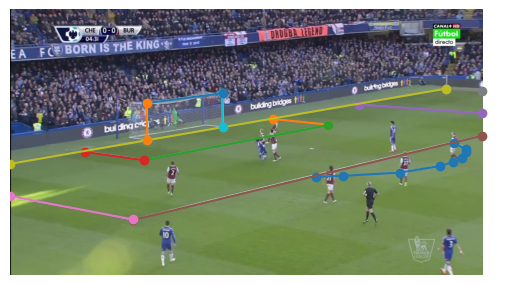

In [44]:
import matplotlib.pyplot as plt
import json
import os

# Load the JSON data
filename = "Calibration_Keypoint/00000.json"
with open(filename, 'r') as f:
    data = json.load(f)

# Load the image
img = plt.imread(filename.replace(".json", ".jpg"))  # assuming it's a .jpg, adjust as needed
plt.imshow(img)

# Plot each set of points
for key, points in data.items():
    # Extract x and y coordinates
    x = [point['x'] for point in points]
    y = [point['y'] for point in points]
    
    # Scale the coordinates to the image dimensions
    h, w, _ = img.shape
    x = [i * w for i in x]
    y = [j * h for j in y]
    
    # Draw the shape
    plt.plot(x, y, label=key, marker='o')

plt.axis('off')  # to hide axes

# Display or save the image
plt.show()
#plt.savefig(os.path.splitext(filename)[0] + "_output.jpg", bbox_inches='tight', pad_inches=0)


In [11]:
import zipfile
with zipfile.ZipFile('training.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [13]:
import os

def prepend_to_filenames(directory, prefix):
    """
    Prepend a prefix to all files in the given directory.
    
    :param directory: Path to the directory.
    :param prefix: The prefix to prepend.
    """
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)

        # Ensure we are working with files and not subdirectories
        if os.path.isfile(file_path):
            new_file_path = os.path.join(directory, prefix + filename)
            os.rename(file_path, new_file_path)
            print(f'Renamed {filename} to {prefix + filename}')

target_directory = 'Training1800/images'  # Replace with your directory path
prepend_to_filenames(target_directory, 'DataSet')


Renamed 000881.jpg to DataSet000881.jpg
Renamed 001506.jpg to DataSet001506.jpg
Renamed 001694.jpg to DataSet001694.jpg
Renamed 000094.jpg to DataSet000094.jpg
Renamed 000210.jpg to DataSet000210.jpg
Renamed 001751.jpg to DataSet001751.jpg
Renamed 000119.jpg to DataSet000119.jpg
Renamed 000879.jpg to DataSet000879.jpg
Renamed 001394.jpg to DataSet001394.jpg
Renamed 000305.jpg to DataSet000305.jpg
Renamed 000028.jpg to DataSet000028.jpg
Renamed 000366.jpg to DataSet000366.jpg
Renamed 001045.jpg to DataSet001045.jpg
Renamed 001785.jpg to DataSet001785.jpg
Renamed 001405.jpg to DataSet001405.jpg
Renamed 000642.jpg to DataSet000642.jpg
Renamed 000427.jpg to DataSet000427.jpg
Renamed 001207.jpg to DataSet001207.jpg
Renamed 001425.jpg to DataSet001425.jpg
Renamed 000844.jpg to DataSet000844.jpg
Renamed 000051.jpg to DataSet000051.jpg
Renamed 000272.jpg to DataSet000272.jpg
Renamed 000442.jpg to DataSet000442.jpg
Renamed 001141.jpg to DataSet001141.jpg
Renamed 001542.jpg to DataSet001542.jpg


Renamed 000412.jpg to DataSet000412.jpg
Renamed 000746.jpg to DataSet000746.jpg
Renamed 000931.jpg to DataSet000931.jpg
Renamed 000758.jpg to DataSet000758.jpg
Renamed 000658.jpg to DataSet000658.jpg
Renamed 000853.jpg to DataSet000853.jpg
Renamed 000765.jpg to DataSet000765.jpg
Renamed 000414.jpg to DataSet000414.jpg
Renamed 000512.jpg to DataSet000512.jpg
Renamed 001789.jpg to DataSet001789.jpg
Renamed 001627.jpg to DataSet001627.jpg
Renamed 000967.jpg to DataSet000967.jpg
Renamed 001340.jpg to DataSet001340.jpg
Renamed 000969.jpg to DataSet000969.jpg
Renamed 000970.jpg to DataSet000970.jpg
Renamed 000430.jpg to DataSet000430.jpg
Renamed 000371.jpg to DataSet000371.jpg
Renamed 000619.jpg to DataSet000619.jpg
Renamed 001217.jpg to DataSet001217.jpg
Renamed 001766.jpg to DataSet001766.jpg
Renamed 000326.jpg to DataSet000326.jpg
Renamed 000760.jpg to DataSet000760.jpg
Renamed 000755.jpg to DataSet000755.jpg
Renamed 000324.jpg to DataSet000324.jpg
Renamed 000182.jpg to DataSet000182.jpg


Renamed 001758.jpg to DataSet001758.jpg
Renamed 000457.jpg to DataSet000457.jpg
Renamed 000595.jpg to DataSet000595.jpg
Renamed 001167.jpg to DataSet001167.jpg
Renamed 000102.jpg to DataSet000102.jpg
Renamed 001704.jpg to DataSet001704.jpg
Renamed 000805.jpg to DataSet000805.jpg
Renamed 001538.jpg to DataSet001538.jpg
Renamed 001019.jpg to DataSet001019.jpg
Renamed 000509.jpg to DataSet000509.jpg
Renamed 000223.jpg to DataSet000223.jpg
Renamed 000911.jpg to DataSet000911.jpg
Renamed 000303.jpg to DataSet000303.jpg
Renamed 000827.jpg to DataSet000827.jpg
Renamed 000042.jpg to DataSet000042.jpg
Renamed 001031.jpg to DataSet001031.jpg
Renamed 000411.jpg to DataSet000411.jpg
Renamed 000631.jpg to DataSet000631.jpg
Renamed 000464.jpg to DataSet000464.jpg
Renamed 000062.jpg to DataSet000062.jpg
Renamed 001203.jpg to DataSet001203.jpg
Renamed 000237.jpg to DataSet000237.jpg
Renamed 001156.jpg to DataSet001156.jpg
Renamed 000027.jpg to DataSet000027.jpg
Renamed 001233.jpg to DataSet001233.jpg


Renamed 000044.jpg to DataSet000044.jpg
Renamed 000923.jpg to DataSet000923.jpg
Renamed 000990.jpg to DataSet000990.jpg
Renamed 001446.jpg to DataSet001446.jpg
Renamed 001570.jpg to DataSet001570.jpg
Renamed 001417.jpg to DataSet001417.jpg
Renamed 000788.jpg to DataSet000788.jpg
Renamed 000132.jpg to DataSet000132.jpg
Renamed 000375.jpg to DataSet000375.jpg
Renamed 000169.jpg to DataSet000169.jpg
Renamed 000877.jpg to DataSet000877.jpg
Renamed 000783.jpg to DataSet000783.jpg
Renamed 001271.jpg to DataSet001271.jpg
Renamed 001114.jpg to DataSet001114.jpg
Renamed 001388.jpg to DataSet001388.jpg
Renamed 001550.jpg to DataSet001550.jpg
Renamed 000421.jpg to DataSet000421.jpg
Renamed 000828.jpg to DataSet000828.jpg
Renamed 000614.jpg to DataSet000614.jpg
Renamed 001686.jpg to DataSet001686.jpg
Renamed 001413.jpg to DataSet001413.jpg
Renamed 001626.jpg to DataSet001626.jpg
Renamed 001801.jpg to DataSet001801.jpg
Renamed 001443.jpg to DataSet001443.jpg
Renamed 000449.jpg to DataSet000449.jpg
